In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# sys.path.append(Path().resolve().parent)
# sys.path.append(Path().resolve())
sys.path.append(os.path.join(Path().resolve(), 'DigiLeTs/scripts'))

In [2]:
import cv2
import copy

class DrawingEnv_Core:
    def __init__(self, params: dict) -> None:
        self.size = params["size"]
        self.line_width = params["line_width"]
        self.initial_position = params["initial_position"]
        self.img = None
        self.prev_position = self.initial_position
        
    def init(self, initial_position=None):
        self.img = np.zeros((self.size, self.size,1))
        if initial_position == None:
            self.prev_position = self.initial_position
        else:
            self.prev_position = initial_position
        observation = dict(image=self.img,
                           position=self.prev_position)
        return observation
        
    def step(self, position):
        _img = cv2.line(img=self.img,
                        pt1=(int(self.prev_position[0]*self.size), int(self.prev_position[1]*self.size)),
                        pt2=(int(position[0]*self.size), int(position[1]*self.size)),
                        color=1,
                        thickness=self.line_width,
                        lineType=cv2.LINE_AA,
                        )
        self.img = copy.deepcopy(_img)
        self.prev_position = position
        observation = dict(image=self.img,
                           position=position)
        reward = 0
        done = False
        info = dict()
        return observation, reward, done, info
        
params = dict(size=256,
              line_width=3,
              initial_position=(0.5,0.5),
              )

env = DrawingEnv_Core(params)

In [3]:
from data import read_original_data

In [4]:
import cv2
import copy

def get_image_sequence(instance, size=256, line_width=3):
    
    params = dict(size=256,
              line_width=3,
              initial_position=(instance[0][0],1-instance[0][1]),
              )

    env = DrawingEnv_Core(params)
    observation = env.init()
    
    images = [observation["image"]]
    actions = []
    for i in range(1, len(instance) - 1):
        if instance[i][5] == 0 and instance[i+1][5] == 0:
            if instance[i+1][3] == 0:
                position = (instance[i+1][0], 1-instance[i+1][1])
                
                observation, reward, done, info = env.step(position)
                images.append(observation["image"])
                
                action = (instance[i+1][0]-instance[i][0], instance[i+1][1]-instance[i][1])
                actions.append(action)
    
    images = np.array(images).transpose(0,3,1,2).astype(np.uint8)
    actions = np.array(actions)
    rewards = np.zeros(len(actions))
    dones = np.zeros(len(actions))
    dones[-1] = 1
    return images, actions, rewards, dones


In [5]:
import glob
data_dir = "DigiLeTs/data/preprocessed/complete"
filenames = glob.glob(os.path.join(data_dir, '*_preprocessed'))

In [8]:
import os
for idx in range(1):
    filename = filenames[idx]
    basename = os.path.basename(filename)
    participant = read_original_data(filename)
    if idx < 70:
        save_folder = "Drawing/train"
    else:
        save_folder = "Drawing/validation"
    for s, symbol in enumerate(participant["trajectories"]):
        if s > 9:
            # 数字以外は省略
            break
        for i, _instance in enumerate(symbol):
            
            instance = _instance[:participant["lengths"][s, i]]
            images, actions, rewards, dones = get_image_sequence(instance, size=64, line_width=3)
            dataset = dict()
            dataset["image_bin"] = images
            dataset["action"] = actions
            dataset["reward"] = rewards
            dataset["done"] = dones
            
            break
        break

Reading from: DigiLeTs/data/preprocessed/complete/002-f-22-right_2019-06-05-12-21-29_preprocessed


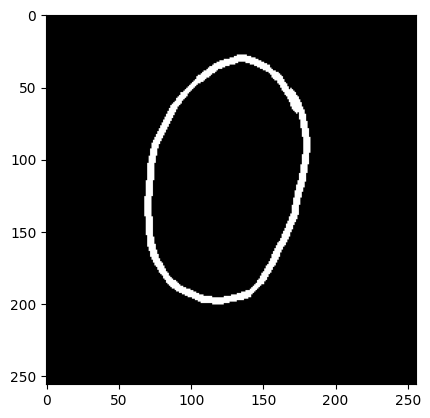

In [9]:
plt.imshow(dataset["image_bin"][-1,0], cmap="gray")